In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import ast
import mne 
import sys
import submitit
import gc
import matplotlib.pyplot as plt
import re 
import matplotlib.pyplot as plt
import numpy as np


# find the eid, pid 

In [47]:
region = 'VISp'
path_table_info = f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/extraction_module/data/eid_probe_info_{region}_{region}.csv'
table = pd.read_csv(path_table_info)
table['pid1'] = table['pid1'].apply(ast.literal_eval)
pids = []
eids = []
for i, row in enumerate(table.iterrows()):
    eid = row[1]['eid']
    pid1 = row[1]['pid1']
    for pid in pid1:
        if os.path.isfile(f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_raw.fif'):
            pids.append(pid)
            eids.append(eid)
print(f'Number of pids with files: {len(pids)} for region {region}')

Number of pids with files: 46 for region VISp


# main funciton for RFM

In [48]:

def RFM(pid, eid):
    from one.api import ONE

    import brainbox.io.one as bbone
    import brainbox.task.passive as passive

    one = ONE(base_url='https://openalyx.internationalbrainlab.org', silent=True)
    one = ONE(password='international')

    path_spikes = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/spikes_{pid}.pkl'
    spikes = pd.read_pickle(path_spikes)
    spike = spikes['spikes']
    spike_times = spike['times']
    spike_depths = spike['depths']
    # Remove any nan depths
    kp_idx = np.where(~np.isnan(spike_depths))[0]
    spike_times = spike_times[kp_idx]
    spike_depths = spike_depths[kp_idx]


    rf_map = bbone.load_passive_rfmap(eid, one=one)
    # Pass this data into brainbox function to find out at what times each voxel on screen was
    # activated
    rf_stim_times, rf_stim_pos, rf_stim_frames = passive.get_on_off_times_and_positions(rf_map)
    # rf_stim_times - time of frame change
    # rf_stim_pos - position of each voxel on (15 x 15) screen
    # rf_stim_frames - frames at which stimulus was turned 'on' (grey to white) or 'off' (grey to
    #                   black) at each position on screen

    # For each position on screen compute average stim epoched activity across depth of probe
    rf_map_avg, depths = passive.get_rf_map_over_depth(rf_stim_times, rf_stim_pos, rf_stim_frames,
                                                spike_times, spike_depths, t_bin=0.01,
                                                d_bin=20, pre_stim=0.05, post_stim=1.5)
    # Take the SVD across to represent RF map across depth
    rf_svd = passive.get_svd_map(rf_map_avg)

    return rf_svd, depths

# submit jobs (one eid, pid example)

In [49]:
joblist = []
executor = submitit.AutoExecutor(folder=os.getcwd()+'/logs/')
executor.update_parameters(mem_gb=16, timeout_min=300, slurm_partition="CPU", cpus_per_task=params['n_jobs'], slurm_comment='compute_epochTFR')
# Submit jobs
for i, (pid, eid) in enumerate(zip(pids, eids)):
    if i >0:
        break
    job = executor.submit(RFM, pid, eid)
    job.job_initial_indice = i
    joblist.append(job)

# Monitor jobs
clean_jobs_live = False
finished_list, finished_order = [], []

print('#### Start waiting for jobs to return #####')
while joblist:
    for i, job in enumerate(joblist):
        if job.done():
            print(f"{len(finished_list)+1} on {len(joblist)}")
            print(f"last job finished: {job.job_id}")
            if clean_jobs_live:
                del job
                gc.collect()
            else:
                finished_list.append(job)
                finished_order.append(job.job_initial_indice)
            joblist.pop(i)
            break

print('#### All jobs completed #####')
print('#### you can start plotting the result #####')

#### Start waiting for jobs to return #####
1 on 1
last job finished: 39303
#### All jobs completed #####
#### you can start plotting the result #####


# load resutls and channel location for one pid, eid example

In [50]:
job = finished_list[0]
rf_svd, depths = job.result() 
rf_on = rf_svd['on']
rf_off = rf_svd['off']

# load channel locations
path_channels = f'/mnt/data/AdaptiveControl/IBLrawdata/eid_data/{eid}/probe_{pid}.pkl'
channels = pd.read_pickle(path_channels)
valid_suffixes = ['1', '2', '4', '5', '6']
condition = channels['acronym'].apply(lambda x: any(x.startswith(f'{region}{suffix}') for suffix in valid_suffixes))
filtered_channels = channels[condition]
filtered_channels = filtered_channels[filtered_channels['channel_labels'] == 0.0]

# plot the result for each channel RFM on and off

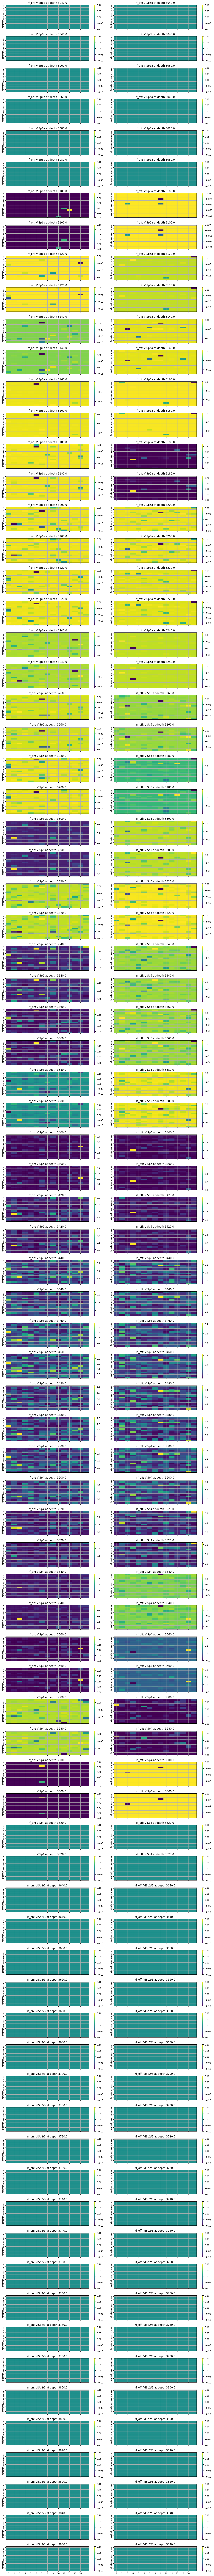

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Number of channels
num_channels = len(filtered_channels)

# Create a figure with subplots (2 columns: one for rf_on, one for rf_off)
fig, axes = plt.subplots(num_channels, 2, figsize=(14, 2 * num_channels), sharex=True)

# If there's only one channel, axes will not be a list of lists, so handle that case
if num_channels == 1:
    axes = [axes]

for i, (index, channel) in enumerate(filtered_channels.iterrows()):
    depth = channel['axial_um']
    idx = np.where(depths == depth)[0][0]
    
    # Plot rf_on for the current channel in the first column
    rf_on_channel = rf_on[idx]
    cax_on = axes[i, 0].imshow(rf_on_channel, aspect='auto', cmap='viridis')
    axes[i, 0].set_title(f'rf_on: {channel["acronym"]} at depth {depth}')
    axes[i, 0].set_xticks(np.arange(14))
    axes[i, 0].set_xticklabels(np.arange(1, 15))
    axes[i, 0].set_yticks(np.arange(14))
    axes[i, 0].set_yticklabels(np.arange(1, 15))
    axes[i, 0].grid(True)
    fig.colorbar(cax_on, ax=axes[i, 0])
    
    # Plot rf_off for the current channel in the second column
    rf_off_channel = rf_off[idx]
    cax_off = axes[i, 1].imshow(rf_off_channel, aspect='auto', cmap='viridis')
    axes[i, 1].set_title(f'rf_off: {channel["acronym"]} at depth {depth}')
    axes[i, 1].set_xticks(np.arange(14))
    axes[i, 1].set_xticklabels(np.arange(1, 15))
    axes[i, 1].set_yticks(np.arange(14))
    axes[i, 1].set_yticklabels(np.arange(1, 15))
    axes[i, 1].grid(True)
    fig.colorbar(cax_off, ax=axes[i, 1])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
